<a href="https://colab.research.google.com/github/krithikp2100/ai-ml/blob/main/Student_NaturalLanguageProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="red"><h1><b><u>MAKE A COPY OF THIS NOTEBOOK SO YOUR EDITS ARE SAVED</u></b></h1></font>

---
---
<h1>🍲<b><i> Natural Language Processing: Classifying Yelp Review Sentiment </i></b></h1>


<center> <img src=https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%203%20-%20NLP/Taco%20Bell%20Reviews.png> </center>




Today, we will develop a machine learning model to determine sentiments expressed in Yelp reviews, classifying them as either positive or negative. This introduces the concept of **sentiment analysis**, a form of natural language processing (NLP) that quantifies individuals' opinions (i.e. **good or bad**) from their textual expressions.

In this notebook, we'll:

1. Explore and manipulate a real Yelp review dataset.
2. Learn word embeddings using pre-trained models.
3. Preprocess text data with tokenization and vectorization.
4. Build and train an RNN for sentiment analysis.
5. Evaluate the model's performance on unseen data.

**Discussion Prompt:** Consider other contexts in which sentiment analysis could be beneficial for businesses or organizations. How might they leverage this technology?

By the end of this, you will not only be able to build a sentiment analysis classifier but also gain insights into the practical challenges and decisions that come with developing AI models.

Let's get started!

In [36]:
#@markdown ##**BEFORE RUNNING ANY CODE, please change your Hardware Accelerator to GPU to train faster!**</h2> {"display-mode":"form"}
#@markdown 1. Click on the **Runtime** menu at the top of the screen.
#@markdown 2. Click **Change Runtime Type**.
#@markdown 3. Choose **T4 GPU** under **Hardware Accelerator**.

#@markdown Once you've done that, run this code cell to check you're correctly connected!

import tensorflow as tf
from IPython.display import Markdown

if tf.test.gpu_device_name():
  display(Markdown("###✅ GPU connected!"))
else:
  display(Markdown("""
###❌ No GPU found!
If you're running into GPU limits when you try to switch, here are some suggestions:
  - Wait 12-24 hours for the limits to reset.
  - Share your copy of the notebook with another Google account that hasn't met the limit, and work through the notebook with that account.
  - Look into a paid subscription or paying for compute units as you go.
  """))


###❌ No GPU found!
If you're running into GPU limits when you try to switch, here are some suggestions:
  - Wait 12-24 hours for the limits to reset.
  - Share your copy of the notebook with another Google account that hasn't met the limit, and work through the notebook with that account.
  - Look into a paid subscription or paying for compute units as you go.
  

In [76]:
#@title **🏗 Setup Cell** {"display-mode":"form", "form-width":"25%"}
#@markdown **Run this to import libraries and download data!**

import pandas as pd   # Great for tables (google spreadsheets, microsoft excel, csv).
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None #suppress warnings

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy.lang.en.stop_words import STOP_WORDS
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)

import spacy
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import locale
locale.getpreferredencoding = lambda: "UTF-8"

import random


!python -m spacy download en_core_web_lg -q
import en_core_web_lg

# Inspirit's util file and discussion exercise answer handler
!wget -q "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Modules/inspiritai_util.py"
from inspiritai_util import handle_discussion_response

from sklearn.metrics.pairwise import cosine_similarity

def cosine(word1, word2):

  vector1 = word1.reshape(1, -1)
  vector2 = word2.reshape(1, -1)

  return cosine_similarity(vector1, vector2)[0][0]

#spacy.prefer_gpu()
text_to_nlp = en_core_web_lg.load()

# Function to convert a word to its vector representation
def word2vec(word):
    return text_to_nlp(word.lower()).vector


# Import our data
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%203%20-%20NLP/yelp_final.csv"

ModuleNotFoundError: No module named 'ann'

## Table of Contents

You can find a more detailed Table of Contents by clicking on the icon on the left sidebar that looks like this: <img src="https://drive.google.com/uc?export=view&id=1AGUz4POrRWu_6n5yI_YdO4qFRr41_PzE" width=20>.

>[📊 Milestone 1: Data Exploration](#scrollTo=DQ267zCBOjet)

>>[1.1. Introducing the Data](#scrollTo=GOrurZT1gqgl)

>>[1.2. Analyzing the Text Data through Word Clouds](#scrollTo=iWbBkEnrgvTJ)

>[🏭 Milestone 2: Processing the Data](#scrollTo=dArbYofKN206)

>>[2.1. Word Embeddings Exploration](#scrollTo=DwjdwGBktqTW)

>>[2.2. Processing the Input Data](#scrollTo=jGXgWNrWtWAR)

>>[2.3. Processing our Output Data](#scrollTo=0bwasn11BfD4)

>[🔄 Milestone 3: Recurrent Neural Networks (RNNs)](#scrollTo=42rl41sUXr0-)

>[(Optional) ⚖️ Milestone 4: Exploring Impact and Ethics](#scrollTo=HCpibGeVgy2i)

>[(Optional Challenge) 🧮 Milestone 5: Linear Algebra and Embeddings](#scrollTo=zcqbg3NSNriB)

>[🤔 Knowledge Check](#scrollTo=2e3T609ocyTA)

>[📋 Cheat Sheets](#scrollTo=arJN8ZYjpqFz)

>>[(Optional reference) Functions](#scrollTo=KtK6uG2fHu2n)

>>[(Optional reference) if statements](#scrollTo=yqp-AanZ4v1r)



---
---
# **📊 Milestone 1: Data Exploration**

## 1.1. Introducing the Data

First, let's start by loading our review data. The data is stored in a file named `yelp_final.csv`. You can see this file for yourself by clicking the folder icon on the left-hand side of the screen. We will use the `read_csv` function from the pandas library to load the data!

In [53]:
yelp = pd.read_csv('yelp_final.csv')
yelp

,business_id,stars,text,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,5,I have no idea why some people give bad review...,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,_1QQZuf4zZOyFCvXc0o6Vg,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg,1,2,0
3,6ozycU1RpktNG2-1BroVtw,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0
4,zp713qNhx8d9KCJJnrw1xA,5,Drop what you're doing and drive here. After I...,wFweIWhv2fREZV_dYkz_1g,7,7,4
...,...,...,...,...,...,...,...
995,-fsCfTYEnJ4s6yStgBnQig,1,If it wasn't for the bad food I would go here ...,3XyuBpNbvrHukaEJyWBAsw,0,0,0
996,_ISHH8x8Qe6IoVTQWegbpQ,1,This was absolutely horrible. I got the suprem...,DRw2GfcyTo8wjx2G27NxlQ,1,2,0
997,AqbgC7Gul5Es1rRzGNLDFA,1,Yeah...notsomuch.\n\nSprinkles is sooooooooo n...,g84VjttN28PWiv_WtdhnSQ,17,20,30
998,QxEUzbLfCTXF6gHWJegWgw,1,I (like others) am at a loss as to why this pl...,d1vSOBq_RauHGpCh7VN7KA,0,0,0


### 1.1.1. Discussion Exercise

In [12]:
#@markdown *1. Which column in the dataset represents the user's REVIEW about the restaurant and would be used as the input to our models?*
answer_1 = "" # @param {"type":"string"}

#@markdown *2. Which column in the dataset can we use to represent the user's SENTIMENT about the restaurant when training our models?*
answer_2 = "" # @param {"type":"string"}

handle_discussion_response(answer_1, answer_2)

Please input your responses in the answer boxes above!


### (Optional) 1.1.2. Discussion Exercise

In [13]:
#@markdown *Notice that the business and user identifiers are not real names but appear as random strings. This technique is known as [hashing](https://medium.com/tech-tales/what-is-hashing-6edba0ebfa67), a common method to ensure privacy.*

#@markdown *Discuss why you think real names are not included in this dataset. What are the potential risks of using real names in publicly available data?*
answer = "" # @param {"type":"string"}

handle_discussion_response(answer)

Please input your response in the answer box above!


## 1.2. Analyzing the Text Data through Word Clouds

Currently, our main focus is on the `'text'` column, which contains the reviews. Let's examine some word clouds describing the text data!

Do you know what a word cloud is? If not, run the cell below and take a guess.

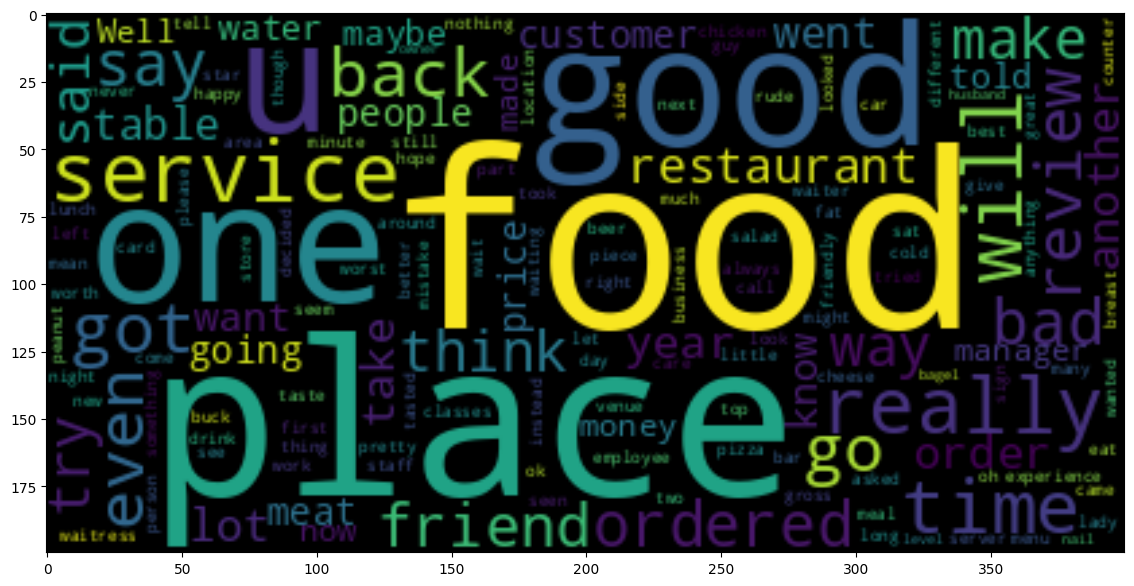

In [14]:
#@title {"display-mode":"form", "form-width":"25%", "run":"auto"}
#@markdown Choose a number of stars from the dropdown to display the word cloud for reviews with that rating!

# Set the number of stars to select reviews
num_stars = 1 # @param ["1","2","3","4","5"] {"type":"raw","allow-input":true}

this_star_text = ''
for review in yelp[yelp['stars'] == num_stars]['text'].values:
    this_star_text += review + ' '

wordcloud = WordCloud()
wordcloud.generate_from_text(this_star_text)
plt.figure(figsize=(14,7))
plt.imshow(wordcloud, interpolation='bilinear');

### 1.2.1. Discussion Exercise

If you're still unsure what a word cloud is showing, each word's size corresponds to how often it shows up in reviews. After looking through the word clouds above, answer the following questions!

In [15]:
#@markdown *1. For each star rating, what words are distinctive to that rating? For example, what words could help you tell that a review was 1 star vs. 5 stars?*
answer_1 = "" # @param {"type":"string"}

#@markdown *2. Are there any words in the bad reviews that surprise you? What about in the good reviews?*
answer_2 = "" # @param {"type":"string"}

#@markdown *3. You might notice that some words show up in both good and bad reviews! Why is this happening? Would these be useful for our sentiment analysis?*
answer_3 = "" # @param {"type":"string"}

handle_discussion_response(answer_1, answer_2, answer_3)

Please input your responses in the answer boxes above!


### 1.2.2. Discussion Exercise

Before we start using machine learning models, imagine you're designing a simple system to tell if a review is **positive** or **negative** based only on what words it uses. This is the basis of a rules-based classifier: it uses specific rules you set to make decisions.

As a group, come up with set of rules using combinations of words that might help identify the sentiment of a review. Write down your ideas below!


In [16]:
#@markdown *1. Describe a combination of words or a pattern that typically indicates a POSITIVE review.*
answer_1 = "" #@param {type:"string"}

#@markdown *2. Describe a combination of words or a pattern that typically indicates a NEGATIVE review.*
answer_2 = "" #@param {type:"string"}

#@markdown *3. Do you think the rules you've created will perform well in accurately classifying review sentiments? Why or why not?*
answer_3 = "" #@param {type:"string"}

handle_discussion_response(answer_1, answer_2, answer_3)

Please input your responses in the answer boxes above!


### (Optional) 1.2.3. Coding Exercise

Now it's time to put your rules to the test! Write a function that uses one of the rules you developed to determine whether a review is **positive** or **negative**. We've provided the basic structure of the function below.

*Hints/tips:*
<details><summary>click to reveal!</summary>

- If you're not sure how to write a function, take a look at [the reference](#scrollTo=KtK6uG2fHu2n).

- Since the function is called `is_good_review_rules_based()`, it should return `True` if the review is good, and `False` if it's bad.
  - Check out the [`if` statement reference](#scrollTo=yqp-AanZ4v1r) if you're stuck!

- You can check if a word is in a given string by typing something like `if 'WORD' in TEXT:`



In [17]:
def is_good_review_rules_based(text):
    # You might start with a simple 'if' statement checking for certain words or phrases.
    pass  # Remove 'pass' and replace it with your implementation.



---
---
# **🏭 Milestone 2: Processing the Data**

As we transition from manually crafting rules to using more sophisticated machine learning techniques, we will prepare our data for analysis using a Recurrent Neural Network (RNN). This type of model is particularly effective for processing sequences, such as text, due to its ability to maintain information across inputs!


## 2.1. Word Embeddings Exploration

Recall that the algorithms we use in machine learning require numerical input, so we need some way of converting the words in our reviews to numbers!

The usual way we do this is through **word embeddings**, which are lists of numbers that neural networks have learned to describe a word, by looking through text data and seeing how words show up in similar contexts! As an example, take a look at the following sentences:

- "My friend knows how to play _____."
- "_____ is my favorite instrument!"
- "I can't! I have to go to _____ lessons today."

Words like "guitar" and "piano" could easily fit in these blanks. When creating word embeddings, we will likely have a lot of data where these two words (and other similar words!) show up in similar places, so we would then make the numbers in their word embeddings more similar.


### Word Embedding Visualization

If you didn't get the chance during lecture, please take a look at the [Word2Vec Visualization](https://projector.tensorflow.org/)!

You can click on any of the dots to see what word it is and what the most similar words are! You can also use the search in the upper right corner to analyze specific words.

Once you've tried out a few words, try looking at words that have multiple meanings! What's interesting about their nearest neighbors?

### 2.1.1. Coding Exercise




We will use `en_core_web_md`, a medium-sized Word2Vec model provided by spaCy. This model has been trained on a vast amount of text from the internet, allowing it to understand language by analyzing the words' contexts.

Retrieve the word embedding for the word "student" using the provided `word2vec` function, which is defined in the set-up cell if you're curious. You can use it like so:

```python
EMBEDDING = word2vec(WORD_VARIABLE) # using a pre-defined variable
EMBEDDING = word2vec("WORD") # using the word directly
```

Once you have your code working, try changing "student" to another word. What changes? What doesn't change?

In [18]:
### YOUR CODE HERE

# Define the word you want to analyze
word = "student" # <- Replace with whatever word you'd like to see the vector of

# Retrieve the word embedding vector for the word "student"
word_embedding = None # <- Replace None with the function call to get the vector

# Get the length of the word embedding vector
length_word_embedding = None  # <- Replace None with code to calculate the length of the vector

### END CODE HERE

# Print the word embedding vector and its length
print("Word Embedding:", word_embedding)
print("Length of Word Embedding:", length_word_embedding)


Word Embedding: None
Length of Word Embedding: None


### Similarity Using Word Vectors
It's pretty difficult to get much meaning from lists of 300 numbers, so let's take a look at how we can compare words with a single number.

Word vectors allow us to quantify how similar two words are by comparing their embeddings (i.e. vectors). To measure this similarity, we use the cosine similarity metric, which can be calculated using the function `cosine(vector1, vector2)` (defined in the set-up cell)

![](https://storage.googleapis.com/lds-media/images/cosine-similarity-vectors.original.jpg)

### 2.1.2. Coding Exercise

In the following code cell, we'll define a function called `similarity()` that will take in two words and return the cosine similarity between them.

If you're stuck, unhide the hints below:
<details><summary>click to reveal!</summary>

- If you're unfamiliar with functions, take a look at [the reference](#scrollTo=KtK6uG2fHu2n)!

- Our inputs are words, but we need embeddings to calculate the similarities. How can we convert the words to embeddings and save those values?

In [19]:
def similarity(word1, word2):
  # This function calculates and returns the cosine similarity between word1 and word2

  pass ### <- YOUR CODE HERE: Delete the pass and add your lines of code

similarity(" ", " ") ### <- YOUR CODE HERE: Fill in the " "s with the two words you'd like to compare!

### 2.1.3. Discussion Exercise

In [20]:
#@markdown *1. What is a pair of words with a similarity greater than 0.8?*
answer_1 = "" #@param {type:"string"}

#@markdown *2. What is a pair of words with a similarity less than 0.2?*
answer_2 = "" #@param {type:"string"}

#@markdown *3. Try guessing what the similarity score for "black" and "white" is, then compute the similarity. Why might we be getting this score?*
answer_3 = "" #@param {type:"string"}

handle_discussion_response(answer_1, answer_2, answer_3)

Please input your responses in the answer boxes above!


## 2.2. Processing the Input Data



This code cell will do the following:

1. Take the `text` column of the dataset and convert the words in each review to their embeddings.
2. Make sure every review is the same length for our model later, by inserting 0s at the beginning until each review is as long as the longest review.

If you have time and you're curious on how this is done, feel free to take a look at the code, though it is a bit advanced!

In [21]:
#@markdown ### Run this to process our input data!

### HELPER FUNCTIONS
def tokenize_and_embed(text_data):
    """
    Tokenizes the text data and converts it to word embeddings using SpaCy.
    Args:
        text_data (list): A list of nonempty text strings to be processed.
    Returns:
        list: A list of lists containing embeddings for each token in each document.
    """
    docs = list(text_to_nlp.pipe(text_data))
    embeddings = [[token.vector for token in doc] for doc in docs]
    return embeddings


def standardize_length(embeddings):
    """
    Ensures all embedding lists are the same length by padding shorter ones with zero vectors.
    Args:
        embeddings (list): A list of nonempty lists of embeddings.
    Returns:
        list: A list of lists with padded embeddings to ensure uniform length.
    """
    max_length = max(len(tokens) for tokens in embeddings)
    embedding_dim = len(embeddings[0][0])
    dtype = np.array(embeddings[0][0]).dtype

    padded_embeddings = [
        [np.zeros(embedding_dim, dtype=dtype) for _ in range(max_length - len(tokens))] + tokens
        for tokens in embeddings
    ]

    return padded_embeddings


### DATA PROCESSING
X_text = yelp['text']
X_embeddings = tokenize_and_embed(X_text)  # Tokenize and get embeddings
X_padded = standardize_length(X_embeddings)  # Standardize lengths
X = np.array(X_padded) # Convert to numpy array suitable for model input


With our data processed, we have all of our text data in numerical form! The data is now in the `X` variable for you to use.

Run the cell below to see what one of the reviews looks like now, as well as the shape of the dataset.

In [22]:
print("The first review is now represented as:")
print()
print(X[0])
print()
print(f"The shape of our dataset is now: {X.shape}")

The first review is now represented as:

[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 ...
 [ 0.13893  -0.019056 -0.33891  ...  0.092753  0.28618   0.13646 ]
 [ 0.35041   0.19459  -0.41846  ...  0.51521   0.035368 -0.15206 ]
 [-0.26554   0.33531   0.2186   ... -0.17859  -0.062878  0.16232 ]]

The shape of our dataset is now: (1000, 1085, 300)


### 2.2.1. Discussion Exercise

In [23]:
#@markdown *What do these numbers mean? Try matching them to each of the descriptions below, and run the cell to see if you're correct!*

number_of_numbers_per_word_embedding = 0 # @param {"type":"integer"}
number_of_tokens_per_review = 0 # @param {"type":"integer"}
number_of_reviews = 0 # @param {"type":"integer"}

if (number_of_reviews, number_of_tokens_per_review, number_of_numbers_per_word_embedding) == X.shape:
  print(f"Correct! That means each review is now represented by {number_of_tokens_per_review * number_of_numbers_per_word_embedding:,} numbers, and our entire dataset is {np.prod(X.shape):,} numbers! ")
else:
  print(f"Not quite! As a hint, where else may have you seen {X.shape[0]} and {X.shape[2]} in this notebook?")

Not quite! As a hint, where else may have you seen 1000 and 300 in this notebook?


## 2.3. Processing our Output Data

To simplify our task into a binary classification problem, we will define a new function called `is_good_review` that will translate our 5 stars categories into 2 categories, using the following rule:

- `4`, `5` ➡ `True`
- `1`, `2`, `3` ➡ `False`


We've already provided the function definition below. Fill in the `None` with the correct expression to correctly divide the dataset into two goups, good or bad!

Feel free to check out the [`if` statement reference](#scrollTo=yqp-AanZ4v1r) if you're stuck!

In [24]:
def is_good_review(num_stars):
    # This function categorizes reviews based on the number of stars.
    # It should return True if the review is positive (4 or 5 stars).
    # It should return False if the review is negative (1, 2, or 3 stars).

    # Replace 'None' with the appropriate condition for a positive review.
    if None:  # YOUR CODE HERE
        return None # What should this return?
    else:
        return None

In [25]:
# Apply the function to the 'stars' column to create a new 'is_good_review' column.
# This column will have a Boolean value where True represents a 'good' review and False represents a 'bad' review.
yelp['is_good_review'] = yelp['stars'].apply(is_good_review)

# Display the first few rows to verify the changes.
yelp.head()

,business_id,stars,text,user_id,cool,useful,funny,is_good_review
0,9yKzy9PApeiPPOUJEtnvkg,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,None
1,ZRJwVLyzEJq1VAihDhYiow,5,I have no idea why some people give bad review...,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,None
2,_1QQZuf4zZOyFCvXc0o6Vg,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg,1,2,0,None
3,6ozycU1RpktNG2-1BroVtw,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,None
4,zp713qNhx8d9KCJJnrw1xA,5,Drop what you're doing and drive here. After I...,wFweIWhv2fREZV_dYkz_1g,7,7,4,None


With the data processed, we can finish up with our last step of splitting the data!

Remember that we're focusing on the binary problem of whether the review is good or not, but, as an extra challenge after class, you can try editing the later code to try and predict the star value instead

In [26]:
y = yelp['is_good_review']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

---
---
# **🔄 Milestone 3: Recurrent Neural Networks (RNNs)**



We are now going to explore a special type of neural network called a Recurrent Neural Network (RNN). While we have briefly touched on other types of neural networks before, RNNs are unique because they can process sequences of data in order. This makes them particularly useful for tasks where the sequence or the order of data points is important.


**How Do RNNs Work?**

<img src="https://stanford.edu/~shervine/teaching/cs-230/illustrations/rnn-many-to-many-different-ltr.png?8ca8bafd1eeac4e8c961d9293858407b" width="500">


Unlike traditional neural networks, which treat each input independently, RNNs have loops in them that allow information to persist. In simpler terms, RNNs can remember information about what has been processed so far, enabling them to make predictions based on the sequence of data received.

**Examples of RNN Applications:**

- **Stock Prices Prediction:** RNNs can predict future stock prices by learning from past stock price trends.
- **Language Modeling:** They can predict the next word in a sentence based on the words that came before, which is useful in text auto-completion tools.
- **Weather Forecasting:** RNNs can predict future weather conditions by analyzing the patterns in past weather data.

RNNs are well-suited and indispensable for many tasks in fields like finance, natural language processing, and meteorology!


In [27]:
#@markdown ## Run this to load the RNN Model!
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

class RNNClassifier:
    def __init__(self, num_epochs=30, lstm_units=50, dropout_rate=0.7):
        self.num_epochs = num_epochs
        self.lstm_units = lstm_units
        self.dropout_rate = dropout_rate
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(LSTM(self.lstm_units, return_sequences=True))
        model.add(Dropout(self.dropout_rate))
        model.add(LSTM(self.lstm_units))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(1, activation='sigmoid'))
        optimizer = Adam(learning_rate=0.001)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model

    def fit(self, X_train, y_train, X_val=None, y_val=None, **kwargs):

        """
        Comment is necessary due to how over complicated I made this. - joel

        Fits the model to the training data. Supports optional validation data.
        If validation data is provided, early stopping is used if not it's not! haha

        Args:
            X_train (array): Training data features.
            y_train (array): Training data labels.
            X_val (array, optional): Validation data features.
            y_val (array, optional): Validation data labels.
            **kwargs: Additional keyword arguments to pass to the model's fit method.

        Returns:
            A history object containing training history.
        """

        if X_train is None and y_train is None:
          print("Arguments are none. Retry with correct arguments.")
          return None

        callbacks = kwargs.pop('callbacks', [])

        if X_val is not None and y_val is not None:
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            callbacks.append(early_stopping)
            return self.model.fit(X_train, y_train, epochs=self.num_epochs, validation_data=(X_val, y_val), callbacks=callbacks, batch_size=32, verbose=1, **kwargs)
        else:
            return self.model.fit(X_train, y_train, epochs=self.num_epochs, batch_size=32, verbose=1, callbacks=callbacks, **kwargs)

    def predict(self, *args, **kwargs):
        predictions = self.model.predict(*args, **kwargs).flatten()
        return (predictions > 0.5).astype(int)

    def predict_proba(self, *args, **kwargs):
        return self.model.predict(*args, **kwargs)

    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

    def __getattr__(self, name):
        if name != 'predict' and name != 'predict_proba':
            return getattr(self.model, name)
        else:
            raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")

### 3.1.1. Coding Exercise



We've built the RNN model for you! All you need to do is train it using the `.fit()` function.

In [28]:
#YOUR CODE HERE! Replace the nones!
rnn = RNNClassifier(num_epochs=15, lstm_units=50, dropout_rate=0.5)
rnn.fit(None, None)

Arguments are none. Retry with correct arguments.


### 3.1.2. Coding Exercise


Now, let's evaluate our model's accuracy! Your model needs to **predict** the sentiment, and then you'll **calculate the accuracy** using the `accuracy_score()` function. **Which dataset** should you use?

In [29]:
y_pred = None # YOUR CODE HERE
accuracy = None # YOUR CODE HERE
print(accuracy)

None


In [30]:
#@markdown ### Run this to display the confusion matrix for your model!
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

cnf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix,
                              display_labels=['negative', 'positive'])
disp.plot(cmap='Blues');

InvalidParameterError: The 'y_pred' parameter of confusion_matrix must be an array-like. Got None instead.

Congratulations - you've trained and tested your model! It's not perfect, but a whole lot better than a coin flip :)


### 3.1.3. Discussion Exercise





Accuracy only tells us so much! It's often useful to figure out **what sorts** of mistakes your model makes.

Try entering some reviews below and explore:

*   What kind of reviews does your model classify correctly? For example, do long or short reviews work better?
*   What kind of reviews does your model get wrong? Does it understand sarcasm or other "tricky" language?
*   Does it seem like your model pays attention to particular words?

In [ ]:
#@title Enter a review to see your model's classification {"display-mode":"form", "form-width":"25%"}
example_review = "This was a horrible place!" #@param {type:'string'}

# Assuming the functions tokenize_and_embed, standardize_length, and convert_to_array are defined in the same script or imported
# First, wrap the example review in a list since our functions expect a list of texts
example_reviews = [example_review]

# Tokenize and convert the review text to embeddings
X_embeddings = tokenize_and_embed(example_reviews)  # Tokenize and get embeddings

# Standardize lengths of the embeddings
X_padded = standardize_length(X_embeddings)  # Standardize lengths

# Convert the padded embeddings into a numpy array suitable for the model
X = np.array(X_padded)  # Convert to numpy array suitable for model input

prediction = rnn.predict(X)
if prediction[0]:
  print ("This was a GOOD review!")
else:
  print ("This was a BAD review!")



---
---
# **(Optional) ⚖️ Milestone 4: Exploring Impact and Ethics**



Whenever we explore a new potential use of AI, it is crucial to have a discussion about the **societal and ethical impact** if it were to be implemented at a large scale.

*Illustration: erhui1979/iStock*

<center> <img src="https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%203%20-%20NLP/AI%20Ethics.png"> </center>

### 📈 Who might this AI impact?

An important part of incorporating AI into your businesses is discuss how it would impact all areas of business.
Let's come up with 3 groups of people that would be impacted by an AI that can classify reviews as positive or negative. We will call these groups `stakeholders`.



In [ ]:
stakeholder1 = '' #@param {type:"string"}
stakeholder2 = '' #@param {type:"string"}
stakeholder3 = '' #@param {type:"string"}



*   **Discuss**: For each of those stakeholders, what are some benefits of this AI model? What are some drawbacks?


> *Hint: What do each of those stakeholders care about?*



* **Discuss**: What are some societal outcomes that can occur to if we had a lot of **false positives** (negative reviews misclassified as positive reviews)? How about **false negatives** (positive reviews misclassified as negative reviews)?

*   **Discuss**: What are some potential sources of bias?

*   **Discuss**: What are some other ethical questions you can come up with?






---
---
# **(Optional Challenge) 🧮 Milestone 5: Linear Algebra and Embeddings**

> (Heads-up: this challenge section is math-heavy!)

One reason text embeddings are cool is that we can use them to explore connections in meaning between different words, including calculating similarity between words and completing [analogies](http://epsilon-it.utu.fi/wv_demo/).

To get started, we'll first create a vocabulary of the most common words from our Yelp reviews dataset. We'll use a technique called the Bag of Words (BOW) model with a Counter Vectorizer, which counts how often each word appears. From this, we'll select the top 500 most frequently used words to form our vocabulary.

Next, we'll create a dictionary containing the vectors for all the words in our vocabulary. This dictionary will help us analyze the relationships between words. If you want to use more than 500 words, feel free to change that number!

In [54]:
#@title Run this to define our vocabulary builder! {"display-mode":"form", "form-width":"25%"}
nltk.download('stopwords')
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from collections import Counter

def build_vocab_dict(texts, top_n=500):
    """
    Builds a dictionary of the most common words and their embeddings using SpaCy.

    Args:
        texts (list of str): The list of texts from which to build the vocabulary.
        top_n (int): The number of top words to include in the vocabulary.

    Returns:
        dict: A dictionary mapping words to their embeddings.
    """
    # Tokenize the text and lower case each word
    tokens = [word.lower() for text in texts for word in word_tokenize(text)]

    # Remove stopwords and non-alphabetic tokens
    filtered_tokens = [token for token in tokens if token.isalpha() and token not in stopwords.words('english')]

    # Count the occurrences of each word
    word_counts = Counter(filtered_tokens)

    # Select the top 'top_n' most common words
    most_common_words = [word for word, count in word_counts.most_common(top_n)]

    # Create a dictionary for the most common words and their embeddings
    vocab_dict = {}
    for word in most_common_words:
        token = text_to_nlp.vocab[word]
        if token.has_vector:  # Check if the token has a vector in the model's vocabulary
            vocab_dict[word] = token.vector
        else:
            # Handle out-of-vocabulary words by assigning a zero vector
            embedding_dim = text_to_nlp.vocab.vectors_length
            vocab_dict[word] = np.zeros((embedding_dim,))

    return vocab_dict

# Example usage:
# X_text_example = ["This is the first document.", "This document is the second document.", "And this is the third one."]
# vocab_dict = build_vocab_dict(X_text_example)
# print(vocab_dict)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [55]:
vocab_dict = build_vocab_dict(X_text, top_n = 800)

# for word, vec in vocab_dict.items():
  # print(word)
  # print(vec)


print ('{} words in our dictionary'.format(len(vocab_dict)))

800 words in our dictionary


In [39]:
print(vocab_dict['soft'].shape)

(300,)


### Cosine Similarity
Next, let's calculate the similarity between two words, using their Word2Vec representations. As before, we'll use cosine similarity to measure the similarity between our vectors.

As an example, imagine we had two three-dimensional vectors:

In [ ]:
v0 = [2,3,1]
v1 = [2,4,1]

Run the code below to plot those vectors, and try changing the numbers above.
How can you make a very small angle between the vectors? How can you make a very large angle?

In [ ]:
#@title Run this to create an interactive 3D plot {"display-mode":"form", "form-width":"25%"}
#NOTE: Would be extra cool with sliders for the vector coordinates! - DREW
#Code from https://stackoverflow.com/questions/47319238/python-plot-3d-vectors
import numpy as np
import plotly.graph_objs as go

def vector_plot(tvects,is_vect=True,orig=[0,0,0]):
    """Plot vectors using plotly"""

    if is_vect:
        if not hasattr(orig[0],"__iter__"):
            coords = [[orig,np.sum([orig,v],axis=0)] for v in tvects]
        else:
            coords = [[o,np.sum([o,v],axis=0)] for o,v in zip(orig,tvects)]
    else:
        coords = tvects

    data = []
    for i,c in enumerate(coords):
        X1, Y1, Z1 = zip(c[0])
        X2, Y2, Z2 = zip(c[1])
        vector = go.Scatter3d(x = [X1[0],X2[0]],
                              y = [Y1[0],Y2[0]],
                              z = [Z1[0],Z2[0]],
                              marker = dict(size = [0,5],
                                            color = ['blue'],
                                            line=dict(width=5,
                                                      color='DarkSlateGrey')),
                              name = 'Vector'+str(i+1))
        data.append(vector)

    layout = go.Layout(
             margin = dict(l = 4,
                           r = 4,
                           b = 4,
                           t = 4)
                  )
    fig = go.Figure(data=data,layout=layout)
    fig.show()


vector_plot([v0,v1])

### 📐 Cosine Similarity Formula

Cosine similarity measures the cosine of the angle between two non-zero vectors. This is used to assess how close two items are. It ranges from -1 (exactly opposite) to 1 (exactly the same), with 0 typically indicating no similarity.
The cosine similarity between two vectors $ \mathbf{A} $ and $ \mathbf{B} $ is calculated as follows:

$$ \text{Cosine Similarity} = \frac{\mathbf{A} \cdot \mathbf{B}}{ \|\mathbf{A}\| \|\mathbf{B}\|} $$

Where:
- $ \mathbf{A} \cdot \mathbf{B} $ is the dot product of the vectors,
- $ \|\mathbf{A}\| $ and $ \|\mathbf{B}\| $ are the norms (or magnitudes) of the vectors. Really, this is just another fancy way of saying "length".

To successfully implement this, here are some helpful hints regarding the functions and libraries you might need:



#### Functions and Methods to Use:
1. **`np.dot()` or `@` operator:** Use this to compute the dot product of two vectors. This function takes two arrays and returns their dot product.
   
   ```python
   dot_product = np.dot(vector1, vector2)
   # or
   dot_product = vector1 @ vector2
   ```

2. **`np.linalg.norm()`:** This function computes the norm (magnitude) of a vector. You'll need to calculate the norm for both vectors involved in the cosine similarity.

   ```python
   norm_vector = np.linalg.norm(vector1)
   ```
   
Use these functions to calculate the cosine similarity according to the formula:

$$ \text{Cosine Similarity} = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|} $$

In [25]:
#Your code here! Assume the vectors are numpy arrays already!
def my_cosine_similarity(vec1, vec2):
    dot_product = vec1 @ vec2 #Fill me in
    norm_vec1 = np.linalg.norm(vec1)   #Fill me in
    norm_vec2 = np.linalg.norm(vec2)   #Fill me in
    similarity = dot_product/(norm_vec1*norm_vec2)  #Fill me in
    return similarity


In [35]:
words = ['cars', 'wheels', 'pasta', 'burger']
vocab_dict['car']
# for word, vec in vocab_dict.items():
#   if
#   print(np.linalg.norm(vec))

array([ 2.0987e-01,  4.6481e-01, -2.4238e-01, -6.5751e-02,  6.0856e-01,
       -3.4698e-01, -2.5331e-01, -4.2590e-01, -2.2277e-01,  2.2913e+00,
       -3.3853e-01,  2.3275e-01, -2.7511e-01,  2.4064e-01, -1.0697e+00,
       -2.6978e-01, -8.0733e-01,  1.8698e+00,  4.5562e-01, -1.4469e-01,
        1.6246e-02, -3.5473e-01,  7.6152e-01, -6.8589e-02,  1.2156e-02,
        9.0520e-03,  1.1131e-01, -3.0746e-01,  2.4168e-01,  1.1400e-01,
        4.3952e-01, -6.6594e-01, -7.3198e-02,  8.0566e-01,  1.1748e-01,
       -3.8758e-01,  1.0691e-01,  3.3697e-01, -1.3188e-01,  1.9364e-01,
        5.5553e-01, -3.4029e-01,  1.7059e-01,  4.0736e-01, -1.6150e-01,
        7.0302e-02,  6.7772e-02, -8.1763e-01,  3.0645e-01, -9.9862e-03,
        9.4606e-02, -5.9763e-01,  1.4192e-01,  1.4857e-01, -3.1535e-01,
        9.9092e-02,  2.0673e-01, -4.4041e-01,  2.1519e-01, -4.1294e-01,
        2.6374e-01, -1.5493e-01,  2.4739e-01,  4.2090e-01,  1.8768e-01,
        4.6904e-02,  9.6848e-02,  2.7431e-02,  1.0633e-01,  3.19

In [ ]:
#@title Run this to check if your function is correct! {"display-mode":"form", "form-width":"25%"}

# Example vectors
vector1 = np.array([1, 2, 3])
vector2 = np.array([1, 5, 7])

# Compute the cosine similarity
similarity_score = my_cosine_similarity(vector1, vector2)
print("Cosine Similarity:", similarity_score)
print("Correct answer: 0.9875414397573881")

## Exercise: Identifying Similar Words Using Your Cosine Similarity Function

In this exercise, you will apply your own implementation of cosine similarity to find the most similar word to a given target word in a vocabulary. You’ll be using the `my_cosine_similarity` function that you wrote earlier, leveraging it to compare word vectors and identify the closest matches.

### What You'll Do

Write a function named `find_most_similar` that utilizes your `my_cosine_similarity` function to determine which word in a predefined vocabulary is most similar to a specified target word. The function should return both the most similar word and its similarity score!

### Some Guidelines

1. **Check Vocabulary**: Initially, ensure the target word is present in the vocabulary. If it’s not, the function should notify the user and not proceed with calculations.
2. **Calculate Similarity**: Use your `my_cosine_similarity` function to compute the similarity between the target word's vector and each vector in the vocabulary.
3. **Track the Highest Score**: As you compute similarities, keep track of the word with the highest similarity score.
4. **Return Results**: After checking all words, return the word with the highest similarity score and the score itself.

Here's an example of how your code will be used!

```python
similar_word, similarity_score = find_most_similar('burger')
if similar_word is not None:
    print(f"The most similar word to 'burger' is '{similar_word}' with a similarity score of {similarity_score:.2f}.")
```


In [34]:
def find_most_similar(target_word):
    # Check if the target word is in the vocabulary dictionary
    if target_word not in vocab_dict:
        print("Word not in dictionary")
        return None, None

    # Retrieve the vector for the target word from the vocabulary dictionary
    vec1 = vocab_dict[target_word]

    # Initialize variables to keep track of the most similar word and the highest similarity score
    most_similar_word = None
    highest_similarity = -np.inf  # Start with the lowest possible similarity

    # Iterate over each word and its vector in the vocabulary dictionary
    for word, vec2 in vocab_dict.items():
        # YOUR CODE HERE: Calculate the similarity using the my_cosine_similarity function
        # Make sure to remove the continue
        continue
    # Return the most similar word along with the similarity score
    return most_similar_word, highest_similarity

### Let's test your function below!

In [35]:
word = "eat" #@param {type:'string'}

similar_word, similarity_score = find_most_similar(word)
if similar_word is not None:
    print(f"The most similar word to '{word}' is '{similar_word}' with a similarity score of {similarity_score:.2f}.")

NameError: name 'vocab_dict' is not defined

## Using Word Analogies

We can use the functions we've built to complete word analogies, similar to the examples found [here](http://epsilon-it.utu.fi/wv_demo/). For instance, consider the analogy:

- Breakfast is to bagel as lunch is to ________,

This involves a bit of "word arithmetic". Suppose $A_1$, $A_2$, and $B_1$ are vectors representing three known words. Our task is to find $B_2$ to complete the analogy:

- $A_1$ is to $A_2$ as $B_1$ is to $B_2$.

Intuitively, this implies that the vector difference between $A_1$ and $A_2$ should be the same as the vector difference between $B_1$ and $B_2$. Thus, we can express this relationship mathematically as:

- $A_1 - A_2 = B_1 - B_2$

### Solving for $B_2$:

To find $B_2$, we rearrange the above equation:

- $B_2 = B_1 - (A_1 - A_2)$

This formulation allows us to compute the expected vector for $B_2$ directly by using vector arithmetic. Once we have the vector for $B_2$, we can use our previously developed functions to identify the word whose vector representation is closest to this computed vector. Try it out and explore different analogies!


In [86]:
# Complete the function below!
def find_analogy(word_a1, word_a2, word_b1):
    # Retrieve vectors for each word
    # Use the word2vec function to get the vector for each word
    a1vec = word2vec(word_a1)
    a2vec = word2vec(word_a2)
    b1vec = word2vec(word_b1)
    b2vec = b1 - (a1 - a2)

    org_similarity = cosine(a1vec, a2vec)
    most_similar_word = None
    highest_similarity = -np.inf  # Initialize with None or a very low value

    for word_b2, b2vec in vocab_dict.items():
        if ( word_b2 == word_b1 or word_b2 == word_a2 ) :
          continue
        highest_similarity = cosine(b1vec,b2vec)
        if org_similarity > highest_similarity:
          most_similar_word = word
          highest_similarity = similarity
          print(highest_similarity)

    return most_similar_word, highest_similarity

    # find_analogy("car","wheels","bird")


In [22]:
vocab_dict[0]

KeyError: 0

In [56]:
def find_analogy(word_a1, word_a2, word_b1):
    # Retrieve vectors for each word
    # Use the word2vec function to get the vector for each word
    a1 = word2vec(word_a1)
    a2 = word2vec(word_a2)
    b1 = word2vec(word_b1)

    # if word_a1 not in vocab_dict or word_a2 not in vocab_dict or word_b1 not in vocab_dict:
    #   missing = [word for word in [word_a1, word_a2, word_b1] if word not in vocab_dict]
    #   print(f"Missing vector for: {', '.join(missing)}")
    #   return None, None

    # Check if any vectors are None (word not in vocabulary)
    # If any of the words are not in the vocabulary, print a message and return None
    if a1 is None or a2 is None or b1 is None:
        missing = [word for word, vec in zip([word_a1, word_a2, word_b1], [a1, a2, b1]) if vec is None]
        print(f"Missing vector for: {', '.join(missing)}")
        return None, None

    vec1 = b1 - (a1 - a2)
    # print(vec1)

    for word, vec2 in vocab_dict.items():
      if cosine(vec1, vec2) > 0.45:
        return word, vec2

In [47]:
vocab_dict['car']

array([ 2.0987e-01,  4.6481e-01, -2.4238e-01, -6.5751e-02,  6.0856e-01,
       -3.4698e-01, -2.5331e-01, -4.2590e-01, -2.2277e-01,  2.2913e+00,
       -3.3853e-01,  2.3275e-01, -2.7511e-01,  2.4064e-01, -1.0697e+00,
       -2.6978e-01, -8.0733e-01,  1.8698e+00,  4.5562e-01, -1.4469e-01,
        1.6246e-02, -3.5473e-01,  7.6152e-01, -6.8589e-02,  1.2156e-02,
        9.0520e-03,  1.1131e-01, -3.0746e-01,  2.4168e-01,  1.1400e-01,
        4.3952e-01, -6.6594e-01, -7.3198e-02,  8.0566e-01,  1.1748e-01,
       -3.8758e-01,  1.0691e-01,  3.3697e-01, -1.3188e-01,  1.9364e-01,
        5.5553e-01, -3.4029e-01,  1.7059e-01,  4.0736e-01, -1.6150e-01,
        7.0302e-02,  6.7772e-02, -8.1763e-01,  3.0645e-01, -9.9862e-03,
        9.4606e-02, -5.9763e-01,  1.4192e-01,  1.4857e-01, -3.1535e-01,
        9.9092e-02,  2.0673e-01, -4.4041e-01,  2.1519e-01, -4.1294e-01,
        2.6374e-01, -1.5493e-01,  2.4739e-01,  4.2090e-01,  1.8768e-01,
        4.6904e-02,  9.6848e-02,  2.7431e-02,  1.0633e-01,  3.19

In [62]:
vocab_dict[0]

KeyError: 0

In [68]:
def distance(vec1, vec2):
  if len(vec1) != len(vec2):
    print("Vectors are not the same length!")
    return None
  sum = 0
  for i in range(len(vec1)):
    sum += np.square(vec1[i]-vec2[i])
  return np.sqrt(sum)

distance(vocab_dict['car'], vocab_dict['turkey'])

np.float32(9.199391)

In [123]:
def find_analogy(word_a1, word_a2, word_b1):
    a1vec = word2vec(word_a1)
    a2vec = word2vec(word_a2)
    b1vec = word2vec(word_b1)

    b2vec = b1vec - (a1vec - a2vec)

    original_similarity = cosine(a1vec, a2vec)
    # print(original_similarity)
    max_error = np.inf

    gencossim = cosine(a1vec,a2vec)
    cossim1 = cosine(word2vec("human"), word2vec("hand"))
    cossim2 = cosine(word2vec("fish") ,word2vec("fin"))
    cossim3 = cosine(word2vec("queen"), word2vec("salad"))
    cossim4 = cosine(word2vec("taco") ,word2vec("guacamole"))
    cossim5 = cosine(word2vec("bird") , word2vec("wing"))
    print("gene vector"+ str(gencossim))
    print(cossim1)
    #print(dist1)
    print(cossim2)
   # print(dist2)
    print(cossim3)
    print(cossim4)
    print(cossim5)

    # test = vocab_dict{"bird", shape(300)}
    for vec in vocab_dict.items()
    test = vocab_dict(test , b2vec)

    print("test: "+test)
    word, vec = random.choice(list(vocab_dict.items()))
    print("rando word:"+word)
#    print(str(word_embedding
  # model1 = gensim.models.Word2Vec(data, min_count=1,                                vector_size=100, window=5)
    dist1 = distance(word2vec("king"), word2vec("pasta"))
    dist2=distance(word2vec("king"),word2vec("burger"))
  #    b2word, b2vec = random.randrange(10)
  #  dotprod1 = word2vec("king") @ word2vec("pasta")
  # #
  #   dotprod2 = word2vec("king") @ word2vec("taco")

  #   dotprod3 = word2vec("queen") @ word2vec("salad")
  #   dotprod4 = word2vec("taco") @ word2vec("guacamole")
  #   dotprod5 = word2vec("car") @ word2vec("fuel")
  #   print(dotprod1)
  #   #print(dist1)
  #   print(dotprod2)
  #  # print(dist2)
  #   print(dotprod3)
  #   print(dotprod4)
  #   print(dotprod5)

    # model1 = gensim.models.Word2Vec(vocab_dict)
    # print("gen mod"+model1.wv.similarity('car','wheel'))

    #vector, distance , searchalgo
    #dimension = 300
    #distance =
 #index.knn_query(query_vector, k=k)-
  # results = hnsw.search_knn(query_vector, k=5)

print(find_analogy('car', 'wheel', 'bird'))

gene vector0.5371256
0.36686295
0.4485538
0.21390471
0.7189245
0.36119586


NameError: name 'find_most_similar' is not defined

In [44]:
for i in range(5):
  if i == 2:
    continue
  print(i)

0
1
3
4


In [87]:
worda1 = "car" #@param {type:'string'}
worda2 = "wheels" #@param {type:'string'}
wordb1 = "birds" #@param {type:'string'}

similar_word, similarity_score = find_analogy(worda1, worda2, wordb1)
print(similar_word)
print(similarity_score)
if similar_word is not None:
    print(f"The word analogous to '{wordb1}' in the context of '{worda1}' to '{worda2}' is '{similar_word}', with a similarity score of {similarity_score:.2f}.")
else:
    print(f"No analogous word found for '{wordb1}' in the context of '{worda1}' to '{worda2}'.")


NameError: name 'b1' is not defined

Word arithmetic doesn't always work perfectly - it's pretty tricky to find good examples! Which can you discover?

If you're looking for a way to expand further on this exercise, you can try seeing what happens when you use [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance), another common measurement, instead of cosine similarity.

---
---

# **🤔 Knowledge Check**

Great job getting through this notebook! If you have time, feel free to go back to the optional sections before this section to delve deeper.

Feel free to use the below questions to ensure you've learned everything from this notebook!




In [ ]:
#@markdown *1. How is a word cloud useful in analyzing text data?*
answer_1 = "" # @param {"type":"string"}

#@markdown *2. What are word embeddings, and why do we need them?*
answer_2 = "" # @param {"type":"string"}

#@markdown *3. What can the cosine function tell us about two word embeddings?*
answer_3 = "" # @param {"type":"string"}

#@markdown *4. Why are we using an Recurrent Neural Network (RNN) for this problem?*
answer_4 = "" # @param {"type":"string"}

handle_discussion_response(answer_1, answer_2, answer_3, answer_4)

---
---

# 📋 Extra Resources

Feel free to use the following cheat sheet as a quick reference!

- [Scikit-learn Pipeline Cheat Sheet](https://docs.google.com/document/d/1NK3wvy9pnpg6vab6AkdzLwGSsNf31NSIsrEYz1IVljk/edit?tab=t.53r5m2rr4htd)


## (Optional reference) Functions

Functions in Python are blocks of reusable code that perform a specific task. They take input (also called parameters), process it, and often return a result. Functions help organize code, reduce repetition, and make programs easier to read and maintain.

### Defining a Function:
```python
def function_name(inputs):
    return result
```

- **Indentation**: The function body must be indented (typically 4 spaces).
- **Parameters**: Functions can accept inputs, which are passed inside the parentheses.
- **Return**: Use `return` to return a value. If no `return`, the function returns `None`.


### Example:
```python
def add(a, b):
    s = a + b
    return s
```

When Python encounters a function being called, it will see what has previously been defined and run the associated code. In the following example, Python would set `a=2` and `b=3` and run the code above, returning `a+b` (that is, `2+3`, or `5`), which we can then store in a variable.

```python
result = add(2, 3)  # 5 is stored in result
```

The functions we've used so far have all been defined for you, but you can define your own whenever you want!

## (Optional reference) `if` statements


### Basic Syntax:
```python
if condition:
    # code to execute if condition is True
```

- **Condition**: An expression that evaluates to `True` or `False`.
- **Indentation**: The code inside the `if` block must be indented

### Example:
```python
age = 18
if age >= 18:
    print("You are an adult.")
```

### `if-else`:
```python
if condition:
    # code if condition is True
else:
    # code if condition is False
```

### `if-elif-else`:
```python
if condition1:
    # code if condition1 is True
elif condition2:
    # code if condition2 is True and condition1 was False
else:
    # code if both conditions are False
```
